<a href="https://colab.research.google.com/github/Techrobo/LocationTrackingApp/blob/main/Pneumonia%20Detection%20CNN%20SVM_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 10: X-Ray Pneumonia Detection (M.Sc Students)

==> *Write*
* *names* 
* *matr. nr.* 
* *study program*
* M.Sc.

*of all assignment group participants here. (double klick here to edit)*

In this assignment, you are tasked with developing your own classifier for pneumonia in X-ray images. You will go through to the complete ML development cycle from loading and preprocessing your data to evaluating your models.

Extract the X-Ray dataset https://rssiste.sharepoint.com/:u:/s/analyticcomputing/ERMTk8Wm091Crev9tV0NEBUBv7ue3bRSG8iiftCCjbOKhA?e=UcjaFB to the same directory as your Jupyter notebook. The data is already split into a training, validation, and testing set. The dataset originates from the paper [Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning
](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5).

You may use any packages, we encountered during the exercises (numpy, matplotlib, scikit-learn, scikit-image, pandas, pytorch) as well as the Python standard library.

You should (at least) address the following points in your development process:

- The dataset is imbalanced. Do at least one of the following:
    - Augment your dataset by including rotated, flipped, or brightened images. This will also improve the generalization capabilities of your model.
    - or: Modify your objective function by weighting the classes differently.
- Optimize the hyperparameters of your models using grid-search or random-search on the validation set.
- Consider at least two classes of models, e.g. CNN and SVM. At least one of your model classes should be some type of neural network implemented in PyTorch.
- After the hyperparameter optimization, select the best-performing models of each class. Evaluate these models on the testing data and visualize your results.

Points (200):

    1. Model Definitions and Training : 80
    2. Model Evaluations : 80
    3. Data Augmentation and Hyperparameter Searching : 40

*Note*! 

This assignment scores (200) counts in 60% threshold (from all 10 assignment, including this project) to be passed for exam. If you already have enough scores then you are not obliged to complete this project (i.e. you already have more than 60% of ALL scores from previous assignment, again, including this project). Otherwise you should do this assignments that it provide double of usual points (200); thus it can increase the overall submisson score. 

For example, if you have more than 660 points out of 1100 total (900-previous assignment + 200-this assignment), then you do not have to perform the assignment . You can consult all of your accumulated points in Illias.


You have two weeks to complete this assignment.

In [4]:
# For Google Colab
!pip install git+https://github.com/Kaggle/kaggle-api.git --upgrade
import os
credentials = {"username":"","key":""}
os.environ['KAGGLE_USERNAME']=credentials["username"]
os.environ['KAGGLE_KEY']=credentials["key"]

  Cloning https://github.com/Kaggle/kaggle-api.git to /tmp/pip-req-build-skribwjc
  Running command git clone -q https://github.com/Kaggle/kaggle-api.git /tmp/pip-req-build-skribwjc
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=78788 sha256=1c1697433034b3490892d8912230d40e267d4c08241f0170515904dada653938
  Stored in directory: /tmp/pip-ephem-wheel-cache-vqywhdku/wheels/2f/2c/1d/18a38a6b617c2c338bdcbf409f3ccc2452799db7dca965d475
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [5]:
# For Google Colab
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
#!unzip chest-xray-pneumonia.zip
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

'Colab Notebooks'
'Getting started.pdf'
 LOM_FAU.docx
'OS GATE.gdoc'
'Other projects'
 rsagarwal-aptitude.pdf
'Self Reconfigurable Autonomous System (Bachelors Project) '
"Shubham's CV.pdf"
'Shubham'\''s Resume (4).pdf'


In [7]:
import os
#import random
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
%matplotlib inline

Read Data Set

In [8]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Dataset-Pneumonia/chest_xray'
#DATA_DIR = 'Dataset-Pneumonia/chest_xray'

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images
VAL_DIR = DATA_DIR + '/val'                               # Contains test images

Data augmentation

In [9]:
img_dim = 256
train_tfms = T.Compose([
    T.RandomAffine(20),
    T.RandomHorizontalFlip(), 
    T.RandomRotation(10),
    T.Resize((img_dim,img_dim)),
    T.ToTensor(), 
#    T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
    T.Resize((img_dim,img_dim)),
    T.ToTensor()
])

In [10]:
train_ds = ImageFolder(TRAIN_DIR, train_tfms)
val_ds = ImageFolder(VAL_DIR, valid_tfms)
test_ds = ImageFolder(TEST_DIR, T.Compose([T.Resize((img_dim,img_dim)), T.ToTensor()]))
len(train_ds), len(val_ds), len(test_ds)

(5216, 16, 624)

In [11]:
datasets = [train_ds, val_ds, test_ds]

In [12]:
classes = train_ds.classes
classes

['NORMAL', 'PNEUMONIA']

In [13]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', classes[target])

Labels: PNEUMONIA


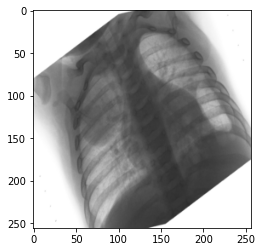

In [14]:
show_sample(*train_ds[2900])

Labels: NORMAL


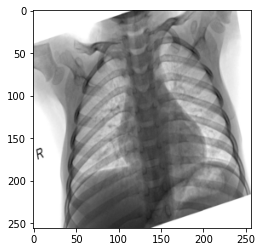

In [15]:
show_sample(*train_ds[800])


Train
   PNEUMONIA  NORMAL
0       3875    1341
Val
   PNEUMONIA  NORMAL
0          8       8
Test
   PNEUMONIA  NORMAL
0        390     234


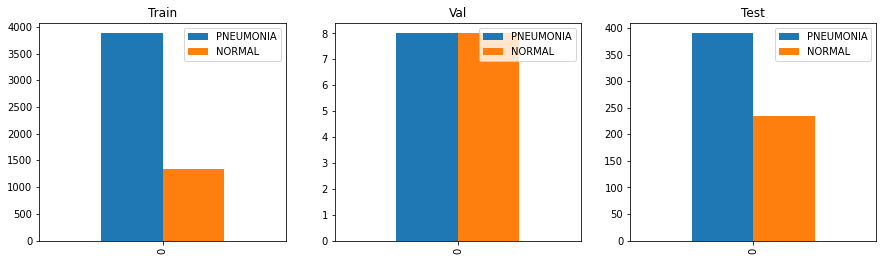

In [16]:
ds_names = ['Train', 'Val', 'Test']
fig, ax = plt.subplots(1, 3, figsize=(15,4))

for i in range(0, len(datasets)):
  targets = pd.Series(datasets[i].targets)
  targets = targets.value_counts()
  df = pd.DataFrame(targets)
  df = df.T
  df.rename(columns={1: 'PNEUMONIA', 0: 'NORMAL'}, inplace=True)
  df.plot.bar(ax=ax[i])
  ax[i].set_title(ds_names[i])
  print(ds_names[i])
  print(df)

We will increase the validation set by splitting the traing set 70 to 30 

In [17]:
df = pd.DataFrame({
  'source': np.full(len(train_ds), 't'),
  'index' : np.arange(len(train_ds))
})

for i in range(len(val_ds)):
  row = pd.Series({
    'source': 'v',
    'index' : i
  })
  row.name = len(train_ds) + i + 1
  df = df.append(row)

In [18]:
train_df, val_df = train_test_split(df, test_size=0.2)
len(train_df), len(val_df)

(4185, 1047)

In [19]:
class DataFrameDataSet(Dataset):
    """Wrap a dataloader to move data to a device"""
    def __init__(self, name, df, train_ds, val_ds):
        self.name = name
        self.df = df
        self.train_ds = train_ds
        self.val_ds = val_ds
        
    def __getitem__(self, index):
        row = self.df.iloc[index]
        if row['source'] == 't':
          #print('t', index, self.train_ds[row['index']][1])
          return (self.train_ds[row['index']][0], self.train_ds[row['index']][1])
          #return self.train_ds[row['index']][0], 4
        else:
          #print('v', index, self.val_ds[row['index']][1])
          return (self.val_ds[row['index']][0], self.val_ds[row['index']][1])
          #return self.val_ds[row['index']][0], 5

    def __len__(self):
        """Number of batches"""
        #print(f'{self.name} df length: {len(self.df)}')
        return len(self.df)

In [22]:
val_df_ds = DataFrameDataSet('val_df_ds', val_df, train_ds, val_ds)
train_df_ds = DataFrameDataSet('train_df_ds', train_df, train_ds, val_ds)

len(train_df_ds), len(val_df_ds)

(4185, 1047)

Unblanced class within training set as pneumoia images are more and normal are less, we use pytorch function to balance it PyTorch's WeightedRandomSampler that each batch from the dataloader has a proportional number of all classes.

In [23]:
labels = []

for index, row in train_df.iterrows():
  if row['source'] == 't':
    labels.append(train_ds[row['index']][1])
  else:
    labels.append(val_ds[row['index']][1])

In [24]:
label_counts = pd.Series(labels)
label_counts.value_counts()

1    3091
0    1094
dtype: int64

In [26]:
class_counts = [1075, 3110]
num_samples = sum(class_counts)

In [27]:
class_weights = [1/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(num_samples)]

In [28]:
sampler = WeightedRandomSampler(weights, len(weights))

In [29]:
batch_size = 32

In [30]:
torch.manual_seed(500)

In [31]:
train_dl = DataLoader(train_df_ds, batch_size, num_workers=2, sampler=sampler, pin_memory=True)
val_dl = DataLoader(val_df_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

In [32]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

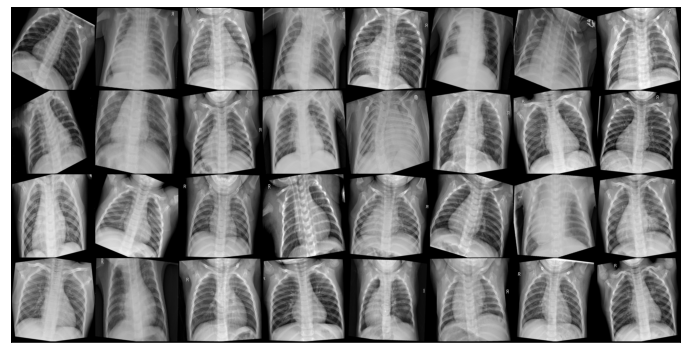

In [36]:
show_batch(train_dl)

In [37]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [38]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [39]:
device = get_default_device()
device

device(type='cuda')

In [40]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## CNN Model - 8 layers

In [41]:
class CNN8(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(262144, 1024),
            nn.ReLU(),
            nn.Linear(1024, len(classes)))
        
    def forward(self, xb):
        return self.network(xb)

In [42]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [43]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

In [45]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

In [46]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [47]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Training CNN Model

In [48]:
epochs = 5
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [49]:
model = to_device(CNN8(), device);
model

CNN8(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=262144, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024

In [50]:
history = [evaluate(model, val_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.7607097029685974, 'val_loss': 0.689569354057312}]

In [51]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.00008, train_loss: 0.6043, val_loss: 0.4000, val_acc: 0.8331



Epoch [1], last_lr: 0.00010, train_loss: 0.2624, val_loss: 0.1947, val_acc: 0.9248



Epoch [2], last_lr: 0.00006, train_loss: 0.2195, val_loss: 0.1794, val_acc: 0.9283



Epoch [3], last_lr: 0.00002, train_loss: 0.1713, val_loss: 0.1709, val_acc: 0.9375



Epoch [4], last_lr: 0.00000, train_loss: 0.1563, val_loss: 0.1756, val_acc: 0.9338
CPU times: user 33.3 s, sys: 7.18 s, total: 40.5 s
Wall time: 34min 38s


In [52]:
train_time = '34min 38s'

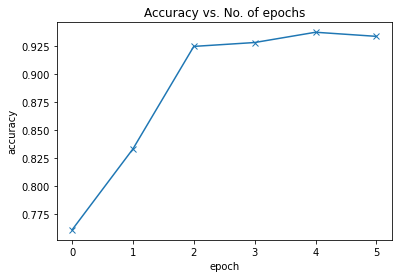

In [53]:
plot_accuracies(history)

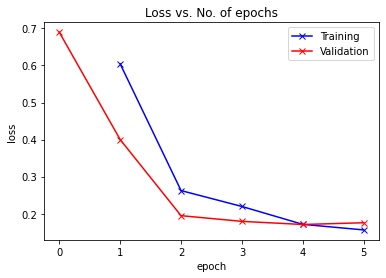

In [54]:
plot_losses(history)

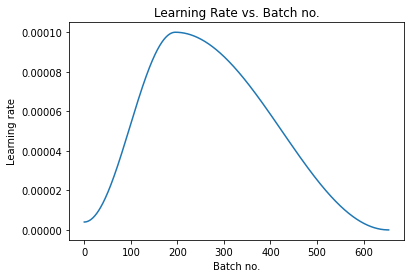

In [55]:
plot_lrs(history)

## Evaluation and Predictions

In [56]:
evaluate(model, test_dl)

{'val_acc': 0.8130208253860474, 'val_loss': 0.501606285572052}

In [57]:
test_acc = 0.8130208253860474
test_loss = 0.501606285572052

**Predictions**

In [58]:
def predict_image(img_data, model):
  img, label = img_data
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds  = torch.max(yb, dim=1)
  plt.imshow(img[0], cmap='gray')
  print('Label:', classes[label], ', Predicted:', classes[preds[0].item()])

Label: PNEUMONIA , Predicted: PNEUMONIA


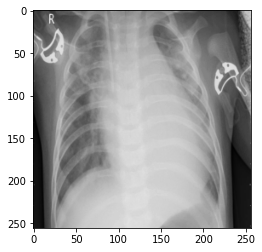

In [59]:
predict_image(test_ds[400], model)

Label: NORMAL , Predicted: PNEUMONIA


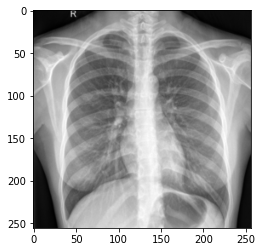

In [60]:
predict_image(test_ds[10], model)

Label: NORMAL , Predicted: PNEUMONIA


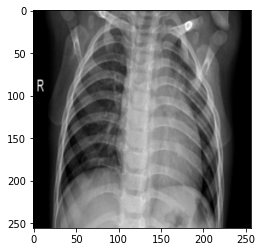

In [61]:
predict_image(test_ds[200], model)

Label: PNEUMONIA , Predicted: PNEUMONIA


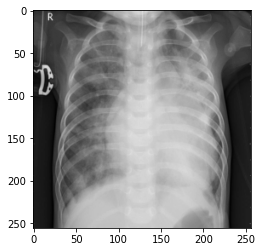

In [62]:
predict_image(test_ds[350], model)

Label: NORMAL , Predicted: NORMAL


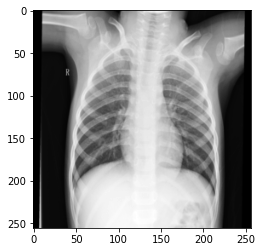

In [63]:
predict_image(test_ds[110], model)

In [64]:
pred_matrix = np.zeros((2,2))
test_index = 0
for i in range(len(test_ds)):
  image, label = test_ds[i]
  xb = image.unsqueeze(0)
  xb = to_device(xb, device)
  preds = model(xb)
  value, prediction = preds[0].max(0)
  pred_matrix[label][prediction.item()] = pred_matrix[label][prediction.item()]  + 1

In [65]:
pred_matrix

array([[135.,  99.],
       [ 20., 370.]])

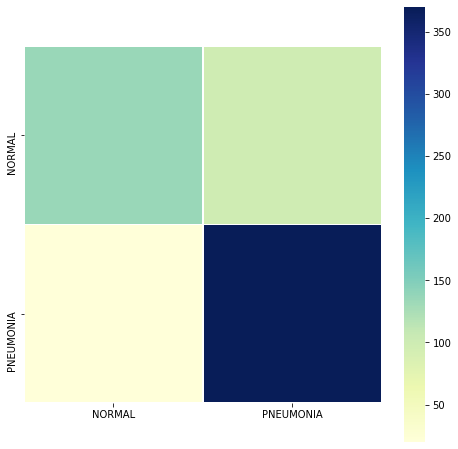

In [66]:
fig, ax = plt.subplots(figsize=(8,8))   
sns.heatmap(pred_matrix, linewidth=0.5, square=True,  cmap="YlGnBu", ax=ax, xticklabels=classes, yticklabels=classes)
plt.show()